# Forest Cover Prediction

- **Class Section: 2019 Summer - Monday 6:30 PM**

- **Project Team: Adam Sohn, Curtis Lin, Erik Hou, Youzhi (Chloe) Wu**


=====================================================================================================================

## 1. Problem Description & Objectives

The objective of this project is to use a machine learning algorithm to predict the forest canopy cover type by using cartographic variables only. The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. 

=====================================================================================================================

## 2. Dataset Description

The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. The dataset describes 30x30 meter cells in four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The dataset contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.
The dataset also contains continuous, unscaled, quantitative data to describe independant variables such as elevation and distance from roads.

Dataset: https://www.kaggle.com/c/forest-cover-type-prediction

=====================================================================================================================

## 3. Project Plan

1. Perform EDA to explore data, noting irregularities and relationships between variables.
2. Pilot study several applicable classification algorithms to hone in on most promising algorithm(s).
3. Apply feature engineering to improve classifier performance: potential algorithms for feature engineering may include
    - Decision tree
    - Random forest regressor
    - Use domain knowledge to featurize soil types
    - PCA to reduce soil types
4. Optimize promising algorithm(s) with bagging, ensemble and cross validations
5. Summarize findings.

=====================================================================================================================

## 4. Package Loading

In [138]:
%matplotlib inline

# General libraries
import csv
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from collections import defaultdict
from numpy import genfromtxt

# SK-learn libraries for learning.
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# SK-learn model packages 
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

from sklearn.decomposition import PCA

import pandas as pd
pd.set_option('display.max_columns', None)

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

## 5. Data Loading


Below are 3 different data loaders to compliment different coding methodologies. Methodologies will be condensed to a single loader in future revision.

In [139]:
### Pandas dataframe for EDA, feature engineering

train_raw_df = pd.read_csv("./forest-cover-type-prediction/train.csv")
train_df = train_raw_df.loc[:,"Elevation":] #remove ID column from df
# test_df_no_label = pd.read_csv('./forest-cover-type-prediction/test.csv') # this dataframe is for final prediction

### Call this function after feature engineering on pandas dataframe to generate numpy array
def data_to_np(my_data=train_raw_df.values):
    '''Takes numpy array as argument in order to return train/dev/test datasets 
    according to desired feature engineering. Default is no feature engineering.'''
    np.random.seed(0)
    data = my_data[1:, :my_data.shape[1]-1]  # avoid getting headers 
    labels = my_data[1:,-1]
    
    shuffle = np.random.permutation(np.arange(data.shape[0]))

    shuffled_data = data[shuffle]
    shuffled_labels = labels[shuffle]
    shuffled_labels = shuffled_labels - 1

    # split the data to 60% train, 20% dev and 20% test
    num_train = int(shuffled_data.shape[0]*0.7)

    train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
    dev_data, dev_labels = shuffled_data[num_train:], shuffled_labels[num_train:]
    train_labels = train_labels.astype('int')
    dev_labels = dev_labels.astype('int')
    
    return train_data, dev_data, train_labels, dev_labels

=====================================================================================================================

## 6. Baseline analysis

### <font color=blue> 6-1. Basic information and descriptive statistics</font>

In [140]:
print("\n### Features:\n")
print(train_raw_df.columns)
print("\nDimension of train_data:", train_raw_df.shape)


### Features:

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil

In [141]:
# Count the number of instances of each class
print(train_df.groupby('Cover_Type').size())

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


> The cover types are equally divided into 7 categories in our training csv. So there is no skewness in our dataset. 

In [142]:
# Geographic information

print("### Geographic information ### \n")
print(train_df.iloc[:,0:3].describe())

# Hydrological information

print("\n### Hydrological information ### \n")
print(train_df.iloc[:,3:5].describe())

# Distance to roadways and fire points

print("\n### Distance to roadways and fire points ### \n")
print(train_df.loc[:,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']].describe())

# Hillshade information (0 to 255 index) 

print("\n### Hillshade information (0 to 255 index) ### \n")
print(train_df.iloc[:,6:9].describe())

# Wilderness area information

print("\n### Wilderness area information ### \n")
print(train_df.iloc[:,10:14].describe())

### Geographic information ### 

          Elevation        Aspect         Slope
count  15120.000000  15120.000000  15120.000000
mean    2749.322553    156.676653     16.501587
std      417.678187    110.085801      8.453927
min     1863.000000      0.000000      0.000000
25%     2376.000000     65.000000     10.000000
50%     2752.000000    126.000000     15.000000
75%     3104.000000    261.000000     22.000000
max     3849.000000    360.000000     52.000000

### Hydrological information ### 

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology
count                      15120.000000                    15120.000000
mean                         227.195701                       51.076521
std                          210.075296                       61.239406
min                            0.000000                     -146.000000
25%                           67.000000                        5.000000
50%                          180.000000                       32.00

In [143]:
# Soil information (binary data)

train_df.iloc[:,14:54].describe()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <font color=blue> 6-2. First pass classifier selection</font>

In [179]:
def score_fn(classifier, feat_eng = train_raw_df.values):
    '''Takes classifier function and feature engineering level as argument and returns score.'''   
    train_data, dev_data, train_labels, dev_labels = data_to_np(feat_eng)
    cls = classifier
    cls.fit(train_data, train_labels)
    cls_pred = cls.predict(dev_data)
    return cls.score(dev_data, dev_labels)

In [180]:
seed = 0 
print('KNearestNeighbors score:', round(score_fn(classifier = KNeighborsClassifier(), 
                                                 feat_eng = train_df.values),4))
print('Logistic Regression score:', round(score_fn(classifier = LogisticRegression(random_state=seed), 
                                                   feat_eng = train_df.values),4))
print('Random Forest score:', round(score_fn(classifier = RandomForestClassifier(random_state=seed), 
                                             feat_eng = train_df.values),4))
print('Decision Tree score:', round(score_fn(classifier = DecisionTreeClassifier(random_state=seed), 
                                             feat_eng = train_df.values),4))
print('Gaussian Naive Bayes:', round(score_fn(classifier = GaussianNB(), 
                                              feat_eng = train_df.values),4))
print('SVM as Base Model for Bagging score:', 
      round(score_fn(classifier = BaggingClassifier(
          base_estimator=svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale'), random_state=seed), 
                     feat_eng = train_df.values),4))
print('Logistic Regression as a Base Model for Bagging:', 
      round(score_fn(classifier = BaggingClassifier(base_estimator=LogisticRegression(
          penalty='l2', solver='liblinear', multi_class='auto'), random_state=seed), 
                     feat_eng = train_df.values),4))
print('KNearestNeighbors for Bagging score:', 
      round(score_fn(classifier = BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=seed), 
                     feat_eng = train_df.values),4))

KNearestNeighbors score: 0.7987
Logistic Regression score: 0.6698
Random Forest score: 0.8232
Decision Tree score: 0.7873
Gaussian Naive Bayes: 0.6032
SVM as Base Model for Bagging score: 0.7531
Logistic Regression as a Base Model for Bagging: 0.6667
KNearestNeighbors for Bagging score: 0.8016


=====================================================================================================================

## 7. Feature Engineering and Sensible Methods

### <font color=blue> 7-1. Feature information</font>

Elevation - Elevation in meters

Aspect - Aspect in degrees azimuth

Slope - Slope in degrees

Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features

Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features

Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway

Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice

Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice

Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points

Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

### <font color=blue> 7-2. Feature engineering based on methodology of variable categorization </font>

#### Plot histogram of each continuous variable to see if can categorize certain variables

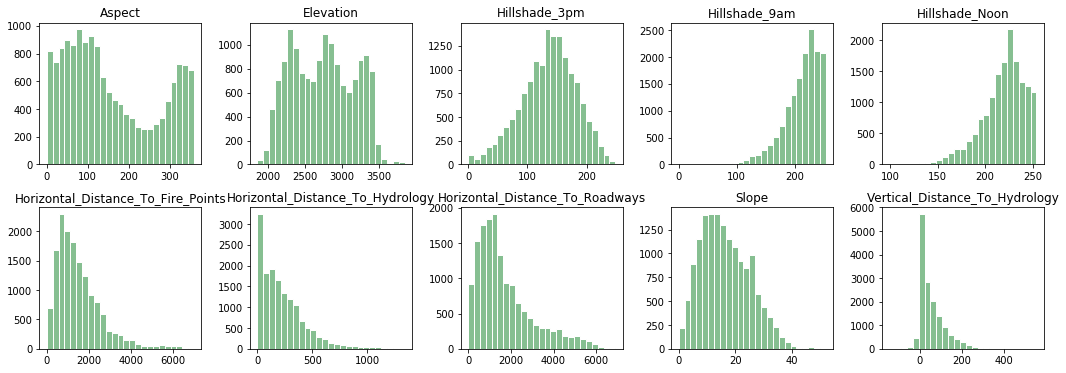

In [154]:
# Plot histogram of each continuous variable to see if can categorize certain variables
train_raw_df_cont.iloc[:,:10].hist(bins=25, grid=False, color='#86bf91', edgecolor='white', 
                               layout=(2,5), figsize=(18,6))
plt.show()

#### <font color = red> Feature Engineering - Round 1 based on above histograms</font>
- **Aspect**: group 1 = [0, 250], group 2 = [250,max]
- **Elevation**: group 1 = [0, 2600], group 2 = [2600, 3100], and group 3 = [3100,max]
- **Soil_Type7 and Soil_Type15**: remove since no data included

In [259]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

# 1. Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df_disc_noLabel.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)

# 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)


# 4. Concatenate df from step 2, df from step 3, and train_df_cover to generate new df for algo
train_df_engineered = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel_1, train_df_cover], axis = 1)

display(train_df_engineered.head())


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [260]:
# Create new train_data and dev_data with first round of data engineering 

my_data = train_df_engineered.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

#### Random Forest Classifier

In [261]:
# Perform Random Forest Classifier with first round feature engineering
rfc = RandomForestClassifier(n_estimators=100, max_features="auto", criterion= "entropy", random_state=seed)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with first feature engineering:

Accuracy score: 0.8527
----------------------------------------------------------------------

# confusion_matrix:


array([[486, 113,   0,   0,  18,   5,  43],
       [ 94, 453,  16,   0,  43,  23,   4],
       [  0,   2, 507,  44,  10,  86,   0],
       [  0,   0,   8, 655,   0,   7,   0],
       [  1,  18,   4,   0, 640,   5,   0],
       [  0,   2,  74,  18,   4, 517,   0],
       [ 24,   2,   0,   0,   0,   0, 610]])

#### Decision Tree Classifier

In [262]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(train_data, train_labels)
dt_pred = dt.predict(dev_data)
dt_score = accuracy_score(dev_labels, dt_pred)

print("# Decision Tree Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %dt_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, dt_pred)

# Decision Tree Classifier with first feature engineering:

Accuracy score: 0.7857
----------------------------------------------------------------------

# confusion_matrix:


array([[411, 180,   1,   0,  16,   7,  50],
       [127, 396,  21,   1,  57,  23,   8],
       [  1,   8, 482,  37,   9, 112,   0],
       [  0,   0,  40, 610,   0,  20,   0],
       [ 15,  44,   5,   0, 595,   9,   0],
       [  0,   6,  99,  14,  10, 486,   0],
       [ 46,   6,   0,   0,   0,   0, 584]])

#### k-Nearest Neighbor Classifier

In [263]:
# k-Nearest Neighbor Classifier

knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)
knn_pred = knn.predict(dev_data)
knn_score = accuracy_score(dev_labels, knn_pred)

print("# k-Nearest Neighbor Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %knn_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, knn_pred)

# k-Nearest Neighbor Classifier with first feature engineering:

Accuracy score: 0.7987
----------------------------------------------------------------------

# confusion_matrix:


array([[417, 138,   2,   0,  31,   3,  74],
       [119, 365,  26,   1,  81,  33,   8],
       [  0,  10, 452,  59,  17, 111,   0],
       [  0,   0,  12, 642,   0,  16,   0],
       [  1,  11,   8,   0, 644,   4,   0],
       [  0,   6,  56,  39,  12, 502,   0],
       [ 25,  10,   0,   0,   0,   0, 601]])

#### <font color = red> Feature Engineering - Round 2</font>
- **Aspect**: Change aspect to within 180 degree; 
- **highwater**: new binary variable to indicate whether Vertical_Distance_To_Hydrology < 0

In [264]:
# Creat a function to change aspect to within 180 degree

def shift_degree(x):
    '''
    A function to shift Aspect 180 degree.
    '''
    if x > 180:
        return x-180
    else:
        return x+180

In [265]:
### Begin Feature Engineering Round 2
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

# 1. Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df_disc_noLabel.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)

# 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)

# 4. Add one new binary variable to indicate whether Vertical_Distance_To_Hydrology < 0 
train_df_cont_noLabel['Highwater'] = train_df_cont_noLabel.Vertical_Distance_To_Hydrology < 0

# 5. Concatenate df from step through step 4, and train_df_cover to generate new df for algo
train_df_engineered2 = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel_1, train_df_cover], axis = 1)

display(train_df_engineered2.head())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Highwater,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,1,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,1,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,2,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,2,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,1,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [266]:
# Create new train_data and dev_data with second round of data engineering 

my_data = train_df_engineered2.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

#### Random Forest Classifier

In [267]:
# Perform Random Forest Classifier with first round feature engineering
rfc = RandomForestClassifier(n_estimators=100 , max_features="auto", criterion= "entropy", random_state=seed)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with first feature engineering:

Accuracy score: 0.8580
----------------------------------------------------------------------

# confusion_matrix:


array([[489, 110,   0,   0,  20,   2,  44],
       [ 95, 451,  17,   0,  44,  22,   4],
       [  0,   1, 517,  39,   8,  84,   0],
       [  0,   0,   8, 656,   0,   6,   0],
       [  1,  20,   5,   0, 637,   5,   0],
       [  0,   2,  62,  19,   2, 530,   0],
       [ 21,   2,   0,   0,   1,   0, 612]])

#### Decision Tree Classifier

In [268]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(train_data, train_labels)
dt_pred = dt.predict(dev_data)
dt_score = accuracy_score(dev_labels, dt_pred)

print("# Decision Tree Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %dt_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, dt_pred)

# Decision Tree Classifier with first feature engineering:

Accuracy score: 0.7870
----------------------------------------------------------------------

# confusion_matrix:


array([[414, 169,   0,   0,  19,   7,  56],
       [126, 400,  18,   1,  55,  25,   8],
       [  2,  10, 481,  41,  10, 105,   0],
       [  0,   0,  39, 617,   0,  14,   0],
       [ 17,  40,   5,   0, 596,  10,   0],
       [  0,  11,  94,  20,   9, 481,   0],
       [ 49,   6,   0,   0,   0,   0, 581]])

#### k-Nearest Neighbor Classifier

In [269]:
# k-Nearest Neighbor Classifier

knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)
knn_pred = knn.predict(dev_data)
knn_score = accuracy_score(dev_labels, knn_pred)

print("# k-Nearest Neighbor Classifier with first feature engineering:\n")
print("Accuracy score: %0.4f" %knn_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, knn_pred)

# k-Nearest Neighbor Classifier with first feature engineering:

Accuracy score: 0.7987
----------------------------------------------------------------------

# confusion_matrix:


array([[417, 138,   2,   0,  31,   3,  74],
       [119, 365,  26,   1,  81,  33,   8],
       [  0,  10, 452,  59,  17, 111,   0],
       [  0,   0,  12, 642,   0,  16,   0],
       [  1,  11,   8,   0, 644,   4,   0],
       [  0,   6,  56,  39,  12, 502,   0],
       [ 25,  10,   0,   0,   0,   0, 601]])

### <font color=blue> 7-3. Feature engineering based on correlation matrix </font>

In [270]:
# Rank feature importance based off Random Forest Regressor results
names = train_df.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
for elem in sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True):
    print(elem)

Features sorted by their score:
(0.4068, 'Elevation')
(0.0845, 'Horizontal_Distance_To_Fire_Points')
(0.0811, 'Horizontal_Distance_To_Roadways')
(0.0424, 'Horizontal_Distance_To_Hydrology')
(0.0394, 'Soil_Type40')
(0.0351, 'Aspect')
(0.0349, 'Vertical_Distance_To_Hydrology')
(0.0333, 'Hillshade_9am')
(0.032, 'Hillshade_Noon')
(0.0319, 'Hillshade_3pm')
(0.0269, 'Soil_Type39')
(0.0264, 'Slope')
(0.015, 'Soil_Type14')
(0.013, 'Soil_Type33')
(0.0109, 'Soil_Type36')
(0.0102, 'Soil_Type30')
(0.0098, 'Soil_Type2')
(0.0087, 'Soil_Type12')
(0.0072, 'Wilderness_Area4')
(0.0062, 'Soil_Type23')
(0.0044, 'Soil_Type15')
(0.0042, 'Soil_Type31')
(0.0038, 'Soil_Type7')
(0.0035, 'Soil_Type34')
(0.0023, 'Soil_Type24')
(0.0022, 'Soil_Type32')
(0.0022, 'Soil_Type3')
(0.0021, 'Soil_Type1')
(0.0019, 'Wilderness_Area2')
(0.0019, 'Soil_Type5')
(0.0018, 'Soil_Type21')
(0.0017, 'Soil_Type25')
(0.0015, 'Soil_Type13')
(0.0014, 'Soil_Type6')
(0.0014, 'Cover_Type')
(0.0013, 'Soil_Type18')
(0.0011, 'Soil_Type35')
(0.

> Feature Engineering efforts will focus on top 10 features, which each explain > 3% of variability: 'Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Aspect', 'Soil_Type39', 'Hillshade_3pm', 'Hillshade_9am', 'Hillshade_Noon'

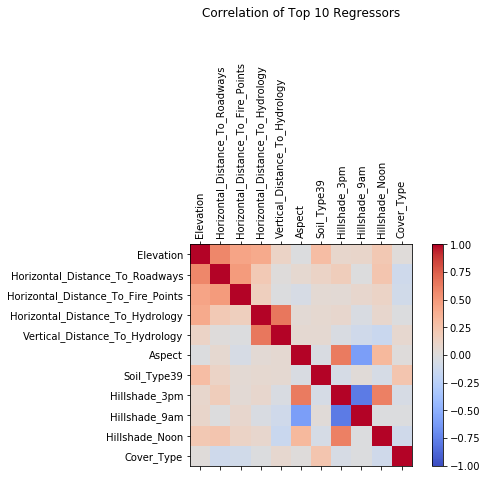

In [271]:
def generate_cor_graph(data, size=(8,6), title = None):
    
    corr = data.corr()
    fig = plt.figure(figsize = size)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.tight_layout()
    plt.title(title, y=2)    
    plt.show()
    
generate_cor_graph(train_df[['Elevation', 'Horizontal_Distance_To_Roadways', 
                             'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 
                             'Vertical_Distance_To_Hydrology', 'Aspect', 'Soil_Type39', 
                             'Hillshade_3pm', 'Hillshade_9am', 'Hillshade_Noon','Cover_Type']], 
                   title = 'Correlation of Top 10 Regressors')

> From the correlation heatmap we can see that 
- **Elevation** is highly correlated with several other variables, such as:
    - Horizontal_Distance_To_Hydrology
    - Horizontal_Distance_To_Roadways
    - Hillshade_Noon
    - Horizontal_Distance_To_Fire_Points
- **Aspect** is highly correlated with the following variables:
    - Hillshade_9am
    - Hillshade_Noon
    - Hillshade_3pm
- **Slope** is highly correlated with the following variables:
    - Hillshade_Noon
- **Horizontal_Distance_To_Hydrology** is highly correlated with the following variables:
    - Vertical_Distance_To_Hydrology
- **Horizontal_Distance_To_Roadways** is highly correlated with the following variables:
    - Horizontal_Distance_To_Fire_Points
- **Hillshade_9am** is highly negatively correlated with the following variables:
    - Hillshade_3pm
- **Hillshade_Noon** is highly positively correlated with the following variables:
    - Hillshade_3pm

> Hillshade is a function of : $Hillshade = 255.0 * \left[ \cos \left[(90 - Altitude)\frac{\pi}{180}\right] \cos(Slope) + \sin\left[(90 - Altitude)\frac{\pi}{180}\right] \sin(Slope) \cos(Azimuth - Aspect) \right]$

> However, none of these features which are most significant for explaining variance have a significant relationship to Cover Type. This is an indication that transformations will not yield much improvement.

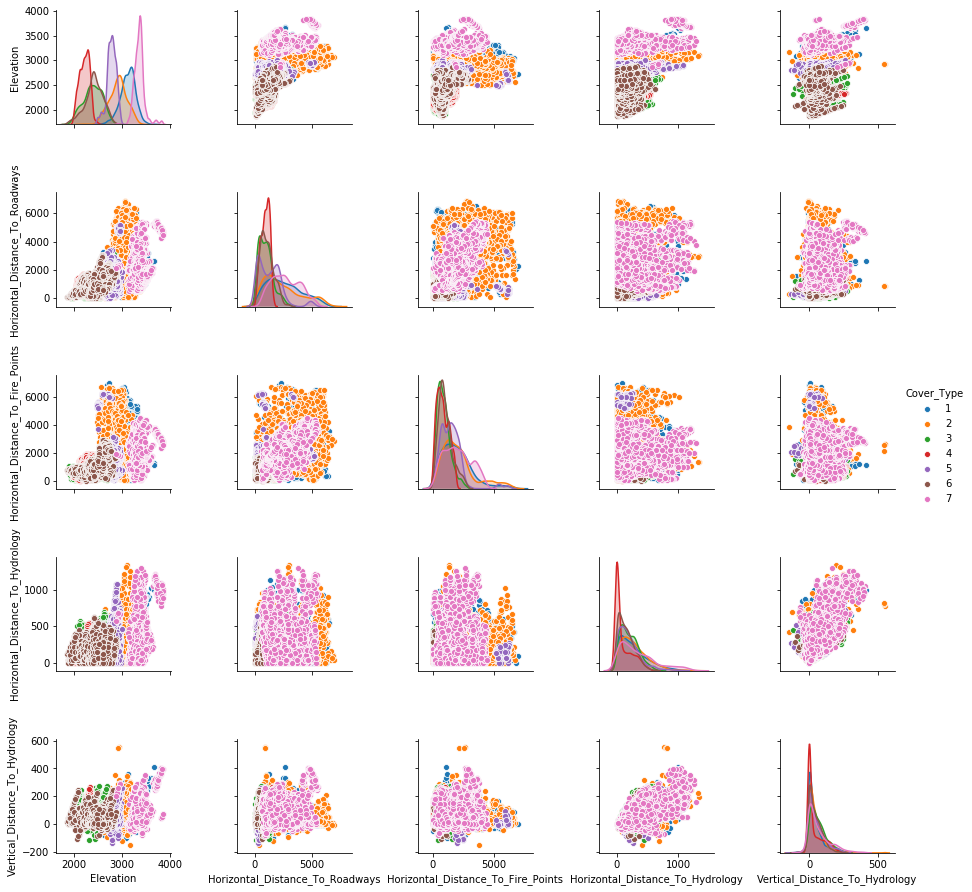

In [272]:
# Plot pairplot between cover type and important variables (based off the RF regressor ranking. Limited to top 6)
sns.pairplot(train_df, hue='Cover_Type', vars=['Elevation', 
                                               'Horizontal_Distance_To_Roadways', 
                                               'Horizontal_Distance_To_Fire_Points', 
                                               'Horizontal_Distance_To_Hydrology', 
                                               'Vertical_Distance_To_Hydrology', 
                                               ])

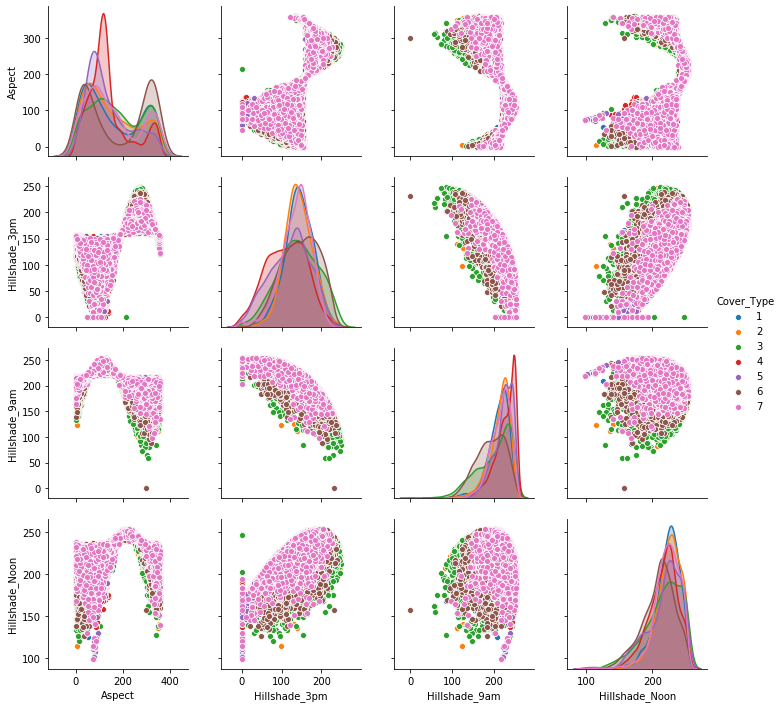

In [273]:
sns.pairplot(train_df, hue='Cover_Type', vars=['Aspect', 'Hillshade_3pm', 'Hillshade_9am', 'Hillshade_Noon'])

> Taking stock of pairplots of highly-correlated features, none show a clear separation of Cover Types. Still, the following transformations were attempted, which did not yield accuracy improvements:
    * Combining 'Horizontal_Distance_To_Hydrology' and 'Vertical_Distance_To_Hydrology' using Pythagorean Theorem for non-vector distance to hydrology.
    * Splitting 'Vertical_Distance_To_Hydrology' to Highwater (Positive) and Lowwater (Negative) to note areas that are likely wetter.

### <font color=blue> 7-4. Feature engineering by adding new soil information </font>

In [274]:
#Import data of featurizer table
soil_feature = pd.read_csv('./forest-cover-type-prediction/soil_feature.csv')

#Establish dataframes as deep copies
train_df2 = train_df.copy(deep= True)

#Aggregating soil types in train_df2 and test_df2 for use as merge index
soil_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']
train_df2['Soil_Type'] = train_df2[soil_cols].idxmax(axis=1)

#Merging train_df2 and test_df2 with soil_feature
train_df2 = train_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')

#Manually reordering columns on train_df2 to make 'Cover_Type' at the end of the list.  
#Note this is not necessary for test2_df due to absence of 'Cover_Type' column. 
#Also eliminating 'Soil_Type' columns.
reordered_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como', 'Cover_Type']
train_df2 = train_df2[reordered_cols]

#### Plot histogram of cover type 1 and 2 of each soil type

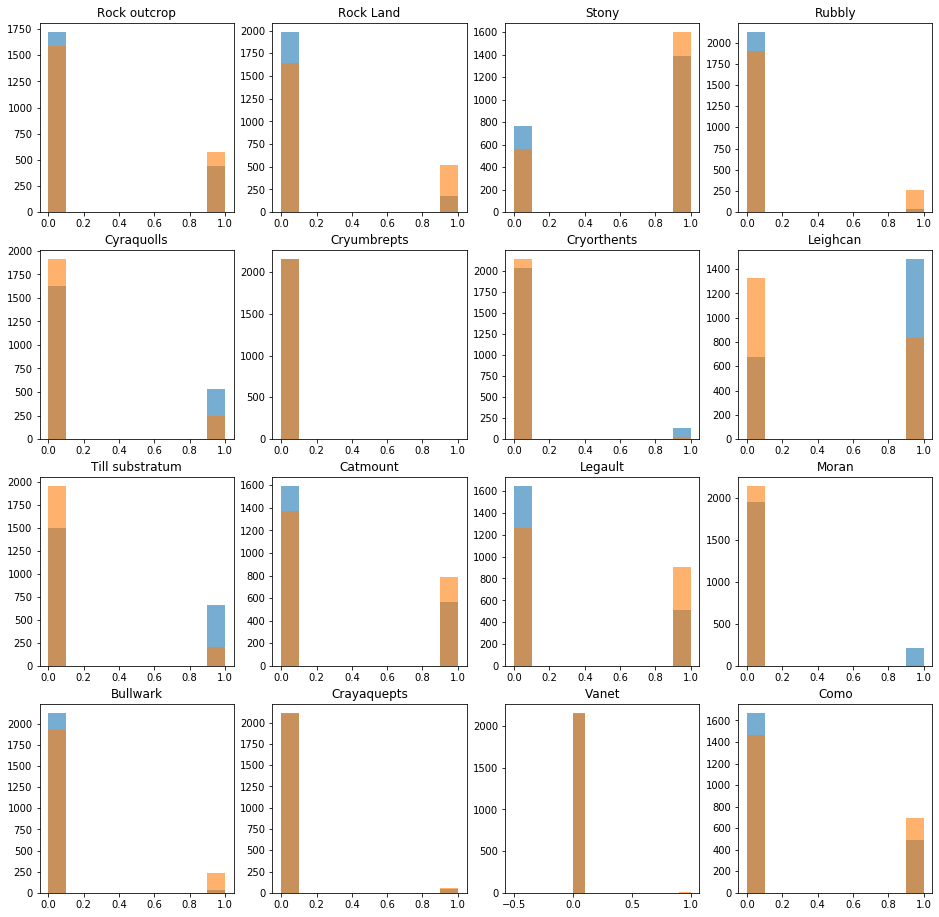

In [275]:
soil_types = [['Rock outcrop', 'Rock Land', 'Stony', 'Rubbly'], 
              ['Cyraquolls', 'Cryumbrepts','Cryorthents', 'Leighcan'], 
              ['Till substratum', 'Catmount', 'Legault', 'Moran'], 
              ['Bullwark', 'Crayaquepts', 'Vanet', 'Como']]

fig, ax = plt.subplots(4, 4, figsize=(16, 16))    
for i in range(4):
    for j in range(4):
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==1][soil_types[i][j]].reset_index(drop=True), 
                      alpha=0.6, label="Cov_1")
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==2][soil_types[i][j]].reset_index(drop=True),
                      alpha=0.6, label="Cov_2")
        ax[i, j].set_title(soil_types[i][j])

#### <font color = red> Feature Engineering - based on soil type that show difference in cover type 1 and 2</font>
- **Soil type**: add 9 soil types; 
- **highwater** remove "highwater" indicator; 
- remove "shift_degree"
- remove 'Soil_Type7',   'Soil_Type15','Horizontal_Distance_To_Hydrology', 'Hillshade_3pm'\</font>

In [276]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df2.iloc[:,0:10]
train_df_disc_noLabel = train_df2.iloc[:,[10,11,12,13,18,19,20,21,22]]
train_df_cover = train_df2.iloc[:,30]


# # 1. Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df.iloc[:, 14:54]

# 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

# labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)

# 4. Concatenate df from step 2, df from step 3, and train_df_cover to generate new df for algo
train_df_engineered = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel, 
                                 train_df_disc_noLabel_1, train_df_cover], axis = 1)

train_df_engineered3 = train_df_engineered.drop(['Soil_Type7', 'Soil_Type15',
                                                'Horizontal_Distance_To_Hydrology', 'Hillshade_3pm'], axis = 1)

display(train_df_engineered3.head())

,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cyraquolls,Cryumbrepts,Cryorthents,Leighcan,Till substratum,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,0,510,221,232,6279,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,-6,390,220,235,6225,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,65,3180,234,238,6121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,118,3090,238,238,6211,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,-1,391,220,234,6172,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [277]:
# Create new train_data and dev_data with third round of data engineering 

my_data = train_df_engineered3.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

#### Random Forest Classifier

In [278]:
# Perform Random Forest Classifier with third round feature engineering
rfc = RandomForestClassifier(n_estimators=100 , max_features="auto", criterion= "entropy", random_state=seed)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with third feature engineering:\n")
print("Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with third feature engineering:

Accuracy score: 0.8501
----------------------------------------------------------------------

# confusion_matrix:


array([[494, 107,   0,   0,  18,   4,  42],
       [ 89, 461,  16,   0,  43,  19,   5],
       [  0,   2, 506,  46,  12,  83,   0],
       [  0,   0,  12, 645,   0,  13,   0],
       [  0,  25,   4,   0, 633,   6,   0],
       [  0,   3,  75,  21,   5, 511,   0],
       [ 27,   3,   0,   0,   0,   0, 606]])

#### Plot histogram of cover type 3 and 6 of each soil type

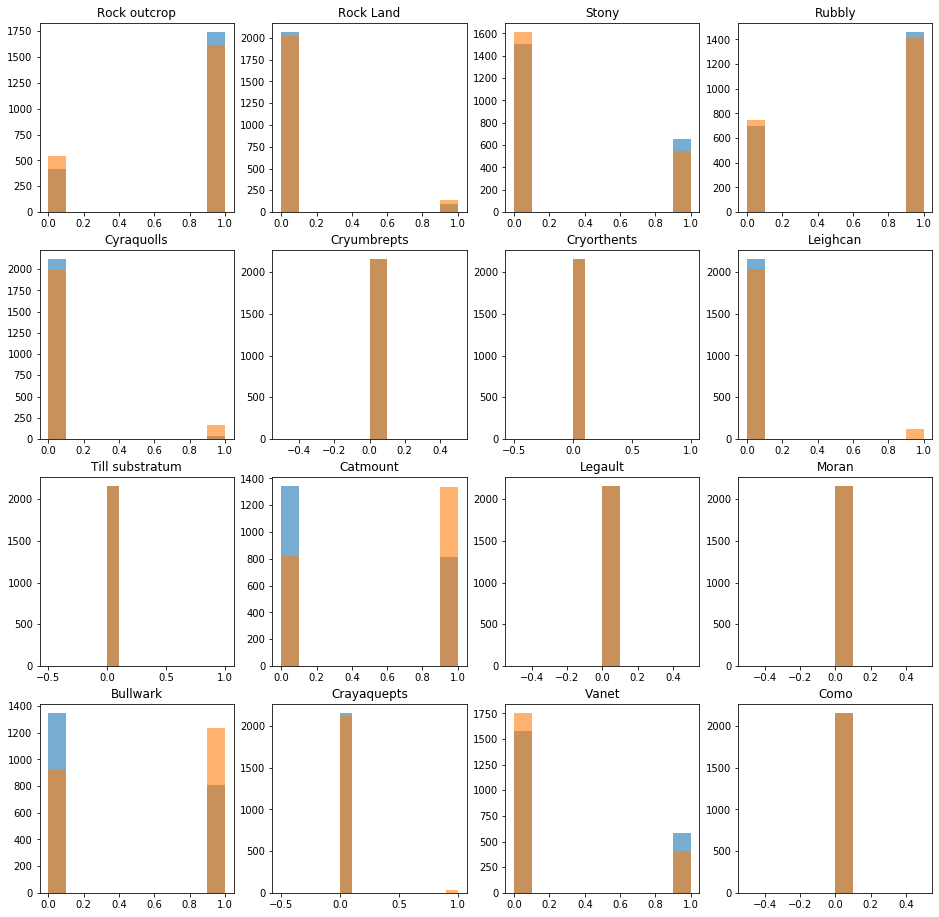

In [279]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))    
for i in range(4):
    for j in range(4):
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==3][soil_types[i][j]].reset_index(drop=True), 
                      alpha=0.6, label="Cov_1")
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==6][soil_types[i][j]].reset_index(drop=True),
                      alpha=0.6, label="Cov_2")
        ax[i, j].set_title(soil_types[i][j])

#### <font color = red> Feature Engineering - based on soil type that show difference in cover type 3 and 6</font>
- **Soil type**: add additional 2 soil types; 

In [280]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df2.iloc[:,0:10]
train_df_disc_noLabel = train_df2.iloc[:,[10,11,12,13,18,19,20,21,22,23,26]]
train_df_cover = train_df2.iloc[:,30]


# Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df.iloc[:, 14:54]
# print(train_df_disc_noLabel_1.head())

# Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

# labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)

# Concatenate df from step 2, df from step 3, and train_df_cover to generate new df for algo
train_df_engineered = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel, 
                                 train_df_disc_noLabel_1, train_df_cover], axis = 1)

train_df_engineered4 = train_df_engineered.drop(['Soil_Type7', 'Soil_Type15',
                                                'Horizontal_Distance_To_Hydrology', 'Hillshade_3pm'], axis = 1)

display(train_df_engineered4.head())


,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cyraquolls,Cryumbrepts,Cryorthents,Leighcan,Till substratum,Catmount,Bullwark,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,0,510,221,232,6279,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,-6,390,220,235,6225,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,65,3180,234,238,6121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,118,3090,238,238,6211,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,-1,391,220,234,6172,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [281]:
# Create new train_data and dev_data with forth round of data engineering 

my_data = train_df_engineered4.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

#### Random Forest Classifier

In [282]:
# Perform Random Forest Classifier with third round feature engineering
rfc = RandomForestClassifier(n_estimators=100 , max_features="auto", criterion= "entropy", random_state=seed)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with third feature engineering:\n")
print("Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with third feature engineering:

Accuracy score: 0.8477
----------------------------------------------------------------------

# confusion_matrix:


array([[478, 118,   0,   0,  18,   5,  46],
       [ 88, 459,  13,   0,  46,  22,   5],
       [  0,   1, 503,  45,  14,  86,   0],
       [  0,   0,  12, 647,   0,  11,   0],
       [  1,  24,   5,   0, 633,   5,   0],
       [  0,   2,  68,  18,   4, 523,   0],
       [ 31,   3,   0,   0,   0,   0, 602]])

### <font color=blue> 7-4. Feature engineering by feature reduction </font>

#### <font color = red> Feature Engineering - Round 4 by Erik</font>
- Use PCA to reduce 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology' to 'Distance_To_Hydrology'
- Use PCA to reduce 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm' to 'Shade'

> Because horizontal distance- and vertical distance to hydrology shows good linear relationship, we will try to reduce the dimension of the two features to one using PCA

In [283]:
# get the train_data for principal component calculation

train_data, dev_data, train_labels, dev_labels = data_to_np(train_df.values)

In [284]:
# We explore how much variance is accounted for when PCA on distance to hydrology
pca_mod = PCA(n_components = 2)
pca_mod.fit(train_data[:,[3,4]])

print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
# print('PCA components: \n', pca_mod.components_)

Explained variance ratio: 
 [0.95699855 0.04300145]
Cumulative explained variance: 
 [0.95699855 1.        ]


In [285]:
# calcuate the reduced data
Distance_To_Hydrology = np.dot(train_df.iloc[:,[3,4]], pca_mod.components_.T[:,:1])

In [286]:
# do the same for 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm' 
# since many of them exhibited pairwise linear relationships

n_comp = 5
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(train_data[:,[1,2,6,7,8]])

print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
# print('PCA components: \n', pca_mod.components_)

Explained variance ratio: 
 [8.58280516e-01 9.52911567e-02 4.35392303e-02 2.72342228e-03
 1.65674302e-04]
Cumulative explained variance: 
 [0.85828052 0.95357167 0.9971109  0.99983433 1.        ]


In [287]:
# calculate the reduced data for shade
shade_3D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:3])
shade_2D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:2])
shade_1D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:1])

In [291]:
## Begin Feature Engineering Round 5
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

# Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df_disc_noLabel.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)

# Remove 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'

train_df_cont_noLabel_1 = train_df_cont_noLabel.drop(['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], axis = 1)

# Remove 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'

train_df_cont_noLabel_1 = train_df_cont_noLabel_1.drop(['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], axis = 1)

# Add the reduced Distance_To_Hydrology to dataframe, convert to int so it's usable for all of the classifiers

train_df_cont_noLabel_1['Distance_To_Hydrology'] = Distance_To_Hydrology.astype(int)

# Add the reduced Shade data to dataframe (use 1D first), so it's usable for all of the classifiers

train_df_cont_noLabel_1['Shade'] = shade_1D.astype(int)

# Concatenate df
train_df_engineered5 = pd.concat([train_df_cont_noLabel_1, train_df_disc_noLabel_1, train_df_cover], axis = 1)


display(train_df_engineered5.head())
# print(train_df_engineered5.shape)

,Elevation,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,Shade,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,510,6279,252,69,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,390,6225,206,75,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,3180,6121,275,146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,3090,6211,260,157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,391,6172,149,64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [292]:
# get the train and dev data and labels after feature engineering round 4

my_data = train_df_engineered5.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

# set the random seed
seed = 0

In [293]:
# Perform Random Forest Classifier with third round feature engineering
rfc = RandomForestClassifier(n_estimators=100 , max_features="auto", criterion= "entropy", random_state=seed)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with third feature engineering:\n")
print("Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with third feature engineering:

Accuracy score: 0.8690
----------------------------------------------------------------------

# confusion_matrix:


array([[497, 117,   0,   0,  13,   4,  34],
       [ 83, 467,  19,   0,  40,  21,   3],
       [  0,   1, 531,  31,   8,  78,   0],
       [  0,   0,   7, 654,   0,   9,   0],
       [  1,  12,   4,   0, 646,   5,   0],
       [  0,   1,  62,  15,   4, 533,   0],
       [ 21,   1,   0,   0,   0,   0, 614]])

## 8. Model Comparions, Findings and Conclusions

### General
* The most direct correlations with cover type come from some soil type
* we have all zero for soil type 7 and 15, smoothing is required for NB if we want to keep the features
* Make sure ID is not used in training 
* The feature space is not sparse because it's mostly binary data and there's only 55 features
* Use cross-validation to optimize hyper-parameter
* The mean of soil_type features are all significantly below 0.5. Mostly below 0.1. Therefore, this means most cover_types have many soil_type = 0. We can try summing the soil_type features and maybe some pattern will emerge (some cover type are corresponding to diverse soil types and that's a good supplement feature to use)

#### KNN
* we will need to standardize the features if we want to make the features roughly contributes equally to the predictions

#### Naive Bayes
* we will need to binarize the dataset to use bernoulliNB since more than half of our variables are binary
* Conditional Independence:
    * We see that after conditioning on a specific cover type, the correlation increases especially when the features besides cover-types are involved. We need to take out the strongly correlated features before training

#### Decision Tree
* Make sure ID is not used in training
* Watch out for over fitting

#### Logistic Regression
* use one vs all
* some regularization

#### Neural Nets

> Can we use different sets of features for different models

https://stats.stackexchange.com/questions/169400/naive-bayes-questions-continus-data-negative-data-and-multinomialnb-in-scikit
Why can't negative data be used here?
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values.

How is scikit-learn handling the continuous data?
If you want to work with bayesian methods use GaussianNb but generally there are a lot of estimators capable of handling continuous data in scikit-learn.